In [3]:
import os
import torch

class Config:
    train_img_dir = os.path.abspath(os.path.join('..', 'data', 'train'))
    val_img_dir = os.path.abspath(os.path.join('..', 'data', 'val'))
    test_img_dir = os.path.abspath(os.path.join('..', 'data', 'test'))

    train_fixations_json = os.path.abspath(os.path.join('..', 'data', 'fixations_train2014.json'))
    val_fixations_json = os.path.abspath(os.path.join('..', 'data', 'fixations_val2014.json'))

    image_size = (256, 192)
    saliency_size = (256, 192)
    saliency_gaussian_sigma = 8.0

    batch_size = 16
    num_workers = 8
    num_epochs = 100
    learning_rate = 1e-4
    weight_decay = 1e-5

    timesteps = 250
    beta_start = 1e-4
    beta_end = 0.02

    cfg_guidance_prob = 0.1  # probability of dropping conditioning image during training
    cfg_guidance_scale = 1.5  # guidance strength during sampling (>1 increases saliency sharpness)

    output_dir = os.path.abspath('./saliency_diffusion_outputs')
    checkpoint_path = os.path.join(output_dir, 'saliency_diffusion_unet.pt')
    sample_dir = os.path.join(output_dir, 'samples')
    gt_saliency_dir = os.path.abspath('./saliency_ground_truth')
    train_saliency_dir = os.path.join(gt_saliency_dir, 'train')
    val_saliency_dir = os.path.join(gt_saliency_dir, 'val')

    device = 'cuda' if os.environ.get('CUDA_VISIBLE_DEVICES') is not None else 'cuda' if __import__('torch').cuda.is_available() else 'cpu'

cfg = Config()
for path in [cfg.output_dir, cfg.sample_dir, cfg.gt_saliency_dir, cfg.train_saliency_dir, cfg.val_saliency_dir]:
    os.makedirs(path, exist_ok=True)
cfg.__dict__

{}

In [9]:
# Option 1: Mixed Precision Training (Automatic Mixed Precision)
# Provides ~2x speedup with negligible accuracy impact

from torch.cuda.amp import autocast, GradScaler

USE_AMP = torch.cuda.is_available()  # Enable if GPU available
USE_MULTI_GPU = torch.cuda.device_count() > 1  # Enable if multiple GPUs

print(f'Mixed Precision (AMP): {"ENABLED" if USE_AMP else "DISABLED"}')
print(f'Multi-GPU: {"ENABLED" if USE_MULTI_GPU else "DISABLED"}')

# Wrap model for multi-GPU if available
if USE_MULTI_GPU:
    print(f'Using {torch.cuda.device_count()} GPUs with DataParallel')
    ddpm = nn.DataParallel(ddpm)
    # Note: Access underlying model with ddpm.module for saving/loading

# Initialize gradient scaler for mixed precision
scaler = GradScaler() if USE_AMP else None

def train_epoch_optimized(epoch_idx: int):
    """Optimized training with mixed precision and optional multi-GPU."""
    if USE_MULTI_GPU:
        ddpm.module.train()
    else:
        ddpm.train()
    
    total_loss = 0.0
    num_batches = 0
    
    for imgs, sal_maps, _ in train_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        
        # Maybe drop conditioning for classifier-free guidance
        if USE_MULTI_GPU:
            imgs = ddpm.module._maybe_drop_condition(imgs) if hasattr(ddpm.module, '_maybe_drop_condition') else imgs
        else:
            imgs = _maybe_drop_condition(imgs)
        
        # Normalize saliency
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        if USE_AMP:
            with autocast():
                if USE_MULTI_GPU:
                    loss = ddpm.module.p_losses(imgs, sal_maps, t)
                else:
                    loss = ddpm.p_losses(imgs, sal_maps, t)
            
            # Scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular training
            if USE_MULTI_GPU:
                loss = ddpm.module.p_losses(imgs, sal_maps, t)
            else:
                loss = ddpm.p_losses(imgs, sal_maps, t)
            
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    scheduler.step()
    return total_loss / max(1, num_batches)

@torch.no_grad()
def validate_epoch_optimized(epoch_idx: int):
    """Optimized validation with mixed precision."""
    if USE_MULTI_GPU:
        ddpm.module.eval()
    else:
        ddpm.eval()
    
    total_loss = 0.0
    num_batches = 0
    
    for imgs, sal_maps, _ in val_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        
        if USE_AMP:
            with autocast():
                if USE_MULTI_GPU:
                    loss = ddpm.module.p_losses(imgs, sal_maps, t)
                else:
                    loss = ddpm.p_losses(imgs, sal_maps, t)
        else:
            if USE_MULTI_GPU:
                loss = ddpm.module.p_losses(imgs, sal_maps, t)
            else:
                loss = ddpm.p_losses(imgs, sal_maps, t)
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / max(1, num_batches)

print('\n✓ Optimized training functions ready')
print('  - Mixed precision (AMP) for 2x speedup')
print('  - Multi-GPU support if available')
print('\nUse train_epoch_optimized() and validate_epoch_optimized() for faster training')

Mixed Precision (AMP): ENABLED
Multi-GPU: DISABLED

✓ Optimized training functions ready
  - Mixed precision (AMP) for 2x speedup
  - Multi-GPU support if available

Use train_epoch_optimized() and validate_epoch_optimized() for faster training


/tmp/ipykernel_319048/2518313842.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if USE_AMP else None


In [ ]:
# Check available resources for parallelization

print('=== System Resources ===')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU count: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'  GPU {i}: {torch.cuda.get_device_name(i)}')
        print(f'    Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB')
    print(f'Current GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.3f} GB')
    print(f'Current GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.3f} GB')

print(f'\nCPU cores: {os.cpu_count()}')
print(f'Current num_workers: {cfg.num_workers}')
print(f'Current batch_size: {cfg.batch_size}')

# Recommendations
print('\n=== Recommendations ===')
if torch.cuda.is_available():
    gpu_mem_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    if gpu_mem_gb >= 24:
        print(f'✓ Large GPU ({gpu_mem_gb:.0f}GB): Try batch_size=16-32')
    elif gpu_mem_gb >= 12:
        print(f'✓ Medium GPU ({gpu_mem_gb:.0f}GB): Try batch_size=12-16')
    else:
        print(f'⚠ Small GPU ({gpu_mem_gb:.0f}GB): Keep batch_size=8 or lower')
    
    if torch.cuda.device_count() > 1:
        print(f'✓ Multiple GPUs detected: Consider DataParallel or DDP')
    
    print(f'✓ Mixed precision (AMP) recommended for 2x speedup')

cpu_cores = os.cpu_count() or 4
recommended_workers = min(cpu_cores // 2, 8)
print(f'✓ Recommended num_workers: {recommended_workers} (you have {cfg.num_workers})')

=== System Resources ===
CUDA available: True
GPU count: 1
  GPU 0: NVIDIA RTX A4500
    Memory: 21.01 GB
Current GPU memory allocated: 0.000 GB
Current GPU memory reserved: 0.000 GB

CPU cores: 20
Current num_workers: 8
Current batch_size: 16

=== Recommendations ===
✓ Medium GPU (21GB): Try batch_size=12-16
✓ Mixed precision (AMP) recommended for 2x speedup
✓ Recommended num_workers: 8 (you have 8)


## Training Optimizations

**Parallelization options:**
1. **Multi-GPU**: Use DataParallel or DistributedDataParallel
2. **Mixed Precision (AMP)**: 2x faster training with minimal accuracy loss
3. **Larger batch size**: More parallel processing (if GPU memory allows)
4. **More workers**: Increase `num_workers` if CPU/RAM allows
5. **Gradient accumulation**: Simulate larger batches without more memory

In [7]:
import json
from functools import lru_cache
from typing import Dict, List, Tuple, Optional
import glob
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import math

print('Using device:', cfg.device)
print('Train dir exists:', os.path.isdir(cfg.train_img_dir))
print('Val dir exists:', os.path.isdir(cfg.val_img_dir))
print('Test dir exists:', os.path.isdir(cfg.test_img_dir))
print('Train fixations JSON exists:', os.path.isfile(cfg.train_fixations_json))
print('Val fixations JSON exists:', os.path.isfile(cfg.val_fixations_json))


Using device: cuda
Train dir exists: True
Val dir exists: True
Test dir exists: True
Train fixations JSON exists: True
Val fixations JSON exists: True


In [12]:
def load_json(path: str) -> Dict:
    with open(path, 'r') as f:
        return json.load(f)

@lru_cache(maxsize=32)
def _gaussian_kernel1d(radius: int, sigma: float) -> np.ndarray:
    ax = np.arange(-radius, radius + 1, dtype=np.float32)
    kernel = np.exp(-(ax ** 2) / (2.0 * sigma ** 2))
    kernel_sum = kernel.sum()
    if kernel_sum > 0:
        kernel /= kernel_sum
    return kernel.astype(np.float32)

def apply_gaussian_blur(array: np.ndarray, sigma: float) -> np.ndarray:
    if sigma <= 0:
        return array
    radius = max(1, int(round(3.0 * sigma)))
    kernel = _gaussian_kernel1d(radius, float(sigma))
    array = array.astype(np.float32, copy=False)
    blurred = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=array)
    blurred = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=blurred)
    return blurred.astype(np.float32)
    
def parse_fixations_json(fixations: Dict, split: str, cache_dir: Optional[str] = None) -> Dict[str, np.ndarray]:
    """Parse SALICON-style fixation annotations into dense saliency maps."""
    if not fixations:
        return {}

    if cache_dir:
        os.makedirs(cache_dir, exist_ok=True)

    # Map image id to file metadata
    img_meta: Dict[int, str] = {}
    dims: Dict[str, Tuple[int, int]] = {}
    for img in fixations.get('images', []):
        img_id = img.get('id')
        fname = img.get('file_name')
        if img_id is None or not fname:
            continue
        img_meta[img_id] = fname
        width = img.get('width')
        height = img.get('height')
        if width and height:
            dims[fname] = (int(width), int(height))

    # Aggregate fixation points per image filename
    mapping: Dict[str, List[Tuple[float, float]]] = {}
    for ann in fixations.get('annotations', []):
        img_id = ann.get('image_id')
        fname = img_meta.get(img_id)
        if not fname:
            continue
        pts = ann.get('fixations') or ann.get('points') or []
        if not pts:
            continue
        bucket = mapping.setdefault(fname, [])
        for p in pts:
            if not isinstance(p, (list, tuple)) or len(p) < 2:
                continue
            try:
                row = float(p[0])
                col = float(p[1])
            except (TypeError, ValueError):
                continue
            if np.isnan(row) or np.isnan(col):
                continue
            # SALICON fixations are 1-indexed (row, col) == (y, x)
            y = row - 1.0
            x = col - 1.0
            bucket.append((y, x))

    saliency_maps: Dict[str, np.ndarray] = {}
    W, H = cfg.saliency_size

    processed = 0
    filenames = sorted(set(img_meta.values()))
    for fname in filenames:
        sal_map = np.zeros((H, W), dtype=np.float32)
        pts = mapping.get(fname, [])
        orig_w, orig_h = dims.get(fname, (None, None))

        if pts:
            for y, x in pts:
                if orig_w and orig_h and orig_w > 1 and orig_h > 1:
                    sy = (y / max(1.0, orig_h - 1)) * (H - 1)
                    sx = (x / max(1.0, orig_w - 1)) * (W - 1)
                else:
                    sy, sx = y, x

                iy = int(round(np.clip(sy, 0, H - 1)))
                ix = int(round(np.clip(sx, 0, W - 1)))
                sal_map[iy, ix] += 1.0

            if cfg.saliency_gaussian_sigma and cfg.saliency_gaussian_sigma > 0:
                sal_map = apply_gaussian_blur(sal_map, cfg.saliency_gaussian_sigma)

            if sal_map.max() > 0:
                sal_map /= sal_map.max()

        saliency_maps[fname] = sal_map.astype(np.float32)
        processed += 1

        if cache_dir:
            stem = os.path.splitext(fname)[0]
            cache_path = os.path.join(cache_dir, f'{stem}.npy')
            np.save(cache_path, sal_map)

    msg_prefix = f"{split.capitalize()} saliency maps"
    if cache_dir:
        print(f"{msg_prefix}: saved {processed} arrays to {cache_dir}")
    else:
        print(f"{msg_prefix}: generated {processed} arrays in memory")

    return saliency_maps
    
try:
    train_fix_raw = load_json(cfg.train_fixations_json)
    val_fix_raw = load_json(cfg.val_fixations_json)
    print('Loaded fixation JSONs.')
except Exception as e:
    print('Error loading or parsing fixation JSONs. Please adapt parse_fixations_json to your format.')
    print(e)
    train_fix_raw, val_fix_raw = None, None

Loaded fixation JSONs.


In [13]:
train_saliency_maps = parse_fixations_json(train_fix_raw, split='train', cache_dir=cfg.train_saliency_dir) if train_fix_raw is not None else {}
val_saliency_maps = parse_fixations_json(val_fix_raw, split='val', cache_dir=cfg.val_saliency_dir) if val_fix_raw is not None else {}

print('Train saliency entries in memory:', len(train_saliency_maps))
print('Val saliency entries in memory:', len(val_saliency_maps))

Train saliency maps: saved 10000 arrays to /home/mlangtry/Computer-Vision/notebooks/saliency_ground_truth/train
Val saliency maps: saved 5000 arrays to /home/mlangtry/Computer-Vision/notebooks/saliency_ground_truth/val
Train saliency entries in memory: 10000
Val saliency entries in memory: 5000
Val saliency maps: saved 5000 arrays to /home/mlangtry/Computer-Vision/notebooks/saliency_ground_truth/val
Train saliency entries in memory: 10000
Val saliency entries in memory: 5000


Train dataset size: 10000
Val dataset size: 5000


Batch shapes: torch.Size([16, 3, 192, 256]) torch.Size([16, 1, 192, 256])


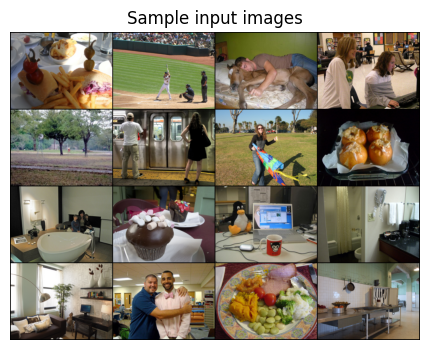

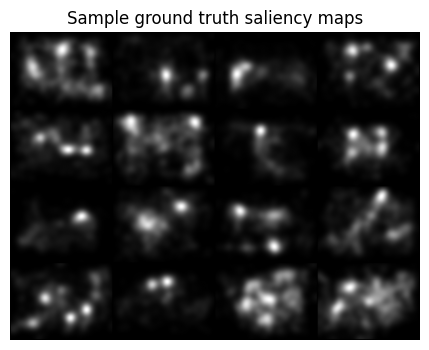

In [14]:
class SaliconSaliencyDataset(Dataset):
    def __init__(self, img_dir: str, saliency_maps: Dict[str, np.ndarray], image_size=(256, 192), saliency_cache_dir: Optional[str] = None):
        self.img_dir = img_dir
        self.saliency_maps = saliency_maps or {}
        self.saliency_cache_dir = saliency_cache_dir
        self.image_size = image_size

        # Collect only images that have saliency info (either in-memory or cached on disk)
        self.image_files = [f for f in os.listdir(img_dir) if self._has_saliency(f)]
        self.image_files.sort()

        self.img_transform = transforms.Compose([
            transforms.Resize((image_size[1], image_size[0])),
            transforms.ToTensor(),
        ])

        # Saliency maps are kept in [0,1] range, single-channel

    def _has_saliency(self, fname: str) -> bool:
        if fname in self.saliency_maps:
            return True
        if not self.saliency_cache_dir:
            return False
        cache_path = os.path.join(self.saliency_cache_dir, f"{os.path.splitext(fname)[0]}.npy")
        return os.path.isfile(cache_path)

    def _load_saliency(self, fname: str) -> np.ndarray:
        sal_map = self.saliency_maps.get(fname)
        if sal_map is None and self.saliency_cache_dir:
            cache_path = os.path.join(self.saliency_cache_dir, f"{os.path.splitext(fname)[0]}.npy")
            if os.path.isfile(cache_path):
                sal_map = np.load(cache_path, allow_pickle=False)
        if sal_map is None:
            raise KeyError(f'No saliency map found for {fname}.')
        return sal_map

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.img_dir, fname)

        img = Image.open(img_path).convert('RGB')
        img = self.img_transform(img)

        sal_map = self._load_saliency(fname)
        H, W = self.image_size[1], self.image_size[0]
        if sal_map.shape != (H, W):
            sal_img = Image.fromarray((sal_map * 255).astype(np.uint8))
            sal_img = sal_img.resize((W, H), resample=Image.BILINEAR)
            sal_tensor = torch.from_numpy(np.array(sal_img)).float() / 255.0
        else:
            sal_tensor = torch.from_numpy(sal_map).float()
        sal_tensor = sal_tensor.unsqueeze(0)  # (1, H, W)

        return img, sal_tensor, fname
    
train_dataset = SaliconSaliencyDataset(
    cfg.train_img_dir,
    train_saliency_maps,
    image_size=cfg.image_size,
    saliency_cache_dir=cfg.train_saliency_dir
)
val_dataset = SaliconSaliencyDataset(
    cfg.val_img_dir,
    val_saliency_maps,
    image_size=cfg.image_size,
    saliency_cache_dir=cfg.val_saliency_dir
)

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))

batch = next(iter(train_loader)) if len(train_dataset) > 0 else None
if batch is not None:
    imgs, sal_maps, fnames = batch
    print('Batch shapes:', imgs.shape, sal_maps.shape)
    grid = vutils.make_grid(imgs, nrow=min(4, imgs.size(0)))
    plt.figure(figsize=(8, 4))
    plt.title('Sample input images')
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    grid_sal = vutils.make_grid(sal_maps, nrow=min(4, sal_maps.size(0)))
    plt.figure(figsize=(8, 4))
    plt.title('Sample ground truth saliency maps')
    plt.imshow(grid_sal[0].cpu(), cmap='gray', vmin=0.0, vmax=1.0) #cmap = hot
    plt.axis('off')
    plt.show()
else:
    print('Warning: Train dataset is empty. Check your paths and JSON mapping.')

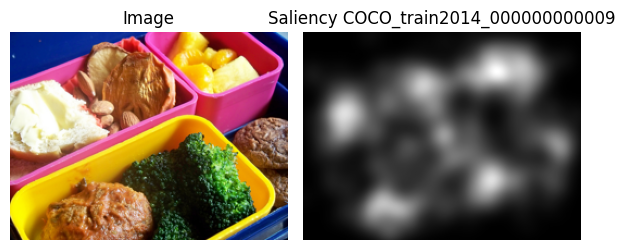

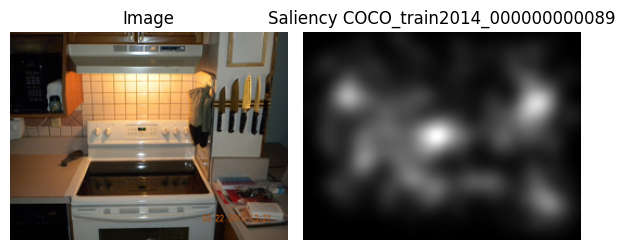

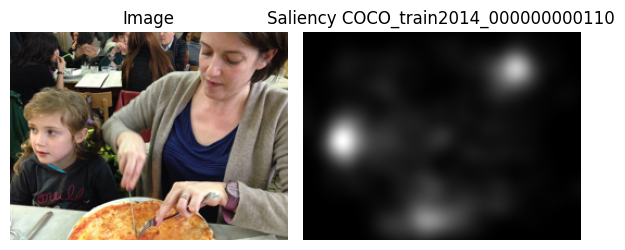

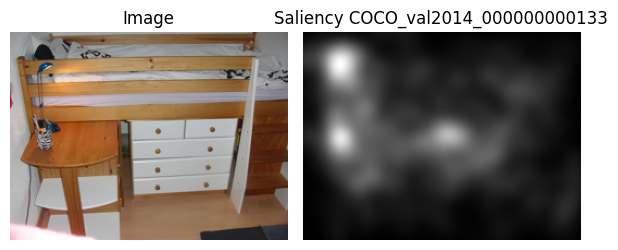

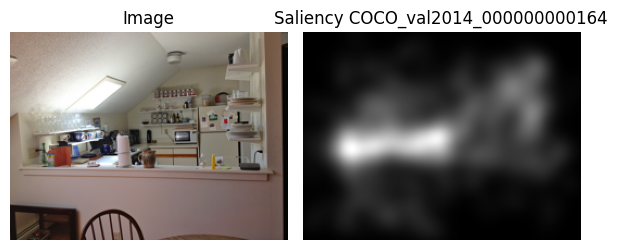

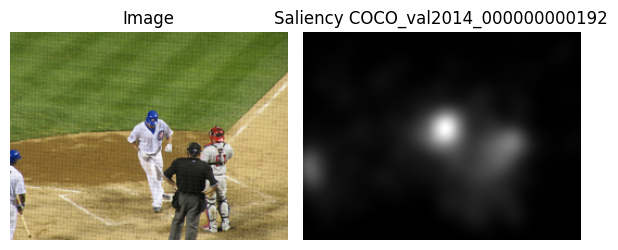

In [15]:
import glob
def visualize_cached_saliency(split: str = 'train', num_samples: int = 3):
    cache_dir = cfg.train_saliency_dir if split == 'train' else cfg.val_saliency_dir
    img_dir = cfg.train_img_dir if split == 'train' else cfg.val_img_dir
    if not os.path.isdir(cache_dir):
        print(f'Cache directory not found: {cache_dir}')
        return

    saliency_paths = sorted(glob.glob(os.path.join(cache_dir, '*.npy')))
    if not saliency_paths:
        print(f'No cached saliency maps found in {cache_dir}')
        return

    for npy_path in saliency_paths[:max(0, num_samples)]:
        sal_map = np.load(npy_path)
        base = os.path.splitext(os.path.basename(npy_path))[0]
        candidates = sorted(glob.glob(os.path.join(img_dir, base + '.*')))
        img = None
        if candidates:
            try:
                img = Image.open(candidates[0]).convert('RGB')
                img = img.resize(cfg.image_size)
            except Exception as exc:
                print(f'Failed to load image for {base}: {exc}')
                img = None

        if img is not None:
            fig, axs = plt.subplots(1, 2, figsize=(6, 3))
            axs[0].imshow(img)
            axs[0].set_title('Image')
            axs[0].axis('off')
            axs[1].imshow(sal_map, cmap='gray', vmin=0.0, vmax=1.0)
            axs[1].set_title(f'Saliency {base}')
            axs[1].axis('off')
        else:
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))
            ax.imshow(sal_map, cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f'Saliency {base}')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

visualize_cached_saliency('train', num_samples=3)
visualize_cached_saliency('val', num_samples=3)

In [16]:
def _groupnorm_groups(num_channels: int) -> int:
    for group in [32, 16, 8, 4, 2]:
        if num_channels % group == 0:
            return group
    return 1

class ResidualBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, time_emb_dim: Optional[int] = None):
        super().__init__()
        self.norm1 = nn.GroupNorm(_groupnorm_groups(in_ch), in_ch, eps=1e-6)
        self.norm2 = nn.GroupNorm(_groupnorm_groups(out_ch), out_ch, eps=1e-6)
        self.act = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        if time_emb_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_emb_dim, out_ch)
            )
        else:
            self.time_mlp = None

    def forward(self, x: torch.Tensor, t_emb: Optional[torch.Tensor] = None) -> torch.Tensor:
        h = self.norm1(x)
        h = self.act(h)
        h = self.conv1(h)
        if self.time_mlp is not None and t_emb is not None:
            h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = self.norm2(h)
        h = self.act(h)
        h = self.conv2(h)
        return h + self.residual(x)


class SpatialSelfAttention(nn.Module):
    """Multi-head self-attention over spatial dimensions with pre-norm and residual."""
    def __init__(self, channels: int, num_heads: int = 4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        assert channels % num_heads == 0, "channels must be divisible by num_heads"
        
        self.norm = nn.GroupNorm(_groupnorm_groups(channels), channels, eps=1e-6)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = self.head_dim ** -0.5

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        residual = x
        
        # Pre-norm
        x = self.norm(x)
        
        # Compute Q, K, V
        qkv = self.qkv(x)  # (B, 3*C, H, W)
        qkv = qkv.view(B, 3, self.num_heads, self.head_dim, H * W)
        qkv = qkv.permute(1, 0, 2, 4, 3)  # (3, B, heads, HW, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each (B, heads, HW, head_dim)
        
        # Attention
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # (B, heads, HW, HW)
        attn = attn.softmax(dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attn, v)  # (B, heads, HW, head_dim)
        out = out.permute(0, 1, 3, 2).reshape(B, C, H, W)
        out = self.proj(out)
        
        return out + residual


class CrossAttention(nn.Module):
    """Cross-attention: query from one feature map, key/value from another, with pre-norm and residual."""
    def __init__(self, channels: int, context_channels: int, num_heads: int = 4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        assert channels % num_heads == 0, "channels must be divisible by num_heads"
        
        self.norm_q = nn.GroupNorm(_groupnorm_groups(channels), channels, eps=1e-6)
        self.norm_kv = nn.GroupNorm(_groupnorm_groups(context_channels), context_channels, eps=1e-6)
        
        self.q_proj = nn.Conv2d(channels, channels, 1)
        self.k_proj = nn.Conv2d(context_channels, channels, 1)
        self.v_proj = nn.Conv2d(context_channels, channels, 1)
        self.out_proj = nn.Conv2d(channels, channels, 1)
        self.scale = self.head_dim ** -0.5

    def forward(self, x: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        _, Cc, Hc, Wc = context.shape
        residual = x
        
        # Pre-norm
        x = self.norm_q(x)
        context = self.norm_kv(context)
        
        # Project to Q, K, V
        q = self.q_proj(x).view(B, self.num_heads, self.head_dim, H * W).permute(0, 1, 3, 2)
        k = self.k_proj(context).view(B, self.num_heads, self.head_dim, Hc * Wc).permute(0, 1, 3, 2)
        v = self.v_proj(context).view(B, self.num_heads, self.head_dim, Hc * Wc).permute(0, 1, 3, 2)
        
        # Attention
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        
        out = torch.matmul(attn, v)
        out = out.permute(0, 1, 3, 2).reshape(B, C, H, W)
        out = self.out_proj(out)
        
        return out + residual


# Sinusoidal positional time embeddings
def sinusoidal_time_embedding(t: torch.Tensor, dim: int) -> torch.Tensor:
    # t: (B,) in [0, timesteps)
    device = t.device
    half_dim = dim // 2
    # log space frequencies
    emb_factor = math.log(10000) / max(1, half_dim - 1)
    # shape (half_dim,)
    freqs = torch.exp(torch.arange(0, half_dim, device=device) * (-emb_factor))
    # normalize t to [0,1]
    t_norm = t.float() / max(1, cfg.timesteps - 1)
    # outer product (B, half_dim)
    angles = t_norm[:, None] * freqs[None, :]
    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
    if dim % 2 == 1:
        # pad one channel if odd dim
        emb = torch.nn.functional.pad(emb, (0, 1), mode='constant', value=0.0)
    return emb

class UNetSaliency(nn.Module):
    def __init__(self, img_channels=3, saliency_channels=1, base_ch=64, time_emb_dim=128, pos_dim=64, attn_heads=4):
        super().__init__()
        in_ch = img_channels + saliency_channels

        # Time embedding: sinusoidal -> linear projection -> MLP
        self.pos_dim = pos_dim
        self.time_proj = nn.Linear(pos_dim, time_emb_dim)
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Encoder (deeper: 3 downsamples + bottleneck)
        self.enc1 = ResidualBlock(in_ch, base_ch, time_emb_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(base_ch, base_ch * 2, time_emb_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualBlock(base_ch * 2, base_ch * 4, time_emb_dim)
        self.pool3 = nn.MaxPool2d(2)
        
        # Bottleneck with attention
        self.bottleneck = ResidualBlock(base_ch * 4, base_ch * 8, time_emb_dim)
        self.bottleneck_self_attn = SpatialSelfAttention(base_ch * 8, num_heads=attn_heads)
        
        # Image encoder for cross-attention context (downsampled to bottleneck resolution)
        self.img_encoder = nn.Sequential(
            nn.Conv2d(img_channels, base_ch * 2, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch * 2, base_ch * 4, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(base_ch * 4, base_ch * 8, 3, stride=2, padding=1),
        )
        self.bottleneck_cross_attn = CrossAttention(base_ch * 8, base_ch * 8, num_heads=attn_heads)

        # Decoder (mirror)
        self.up3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, 2, stride=2)
        self.dec3 = ResidualBlock(base_ch * 8, base_ch * 4, time_emb_dim)
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec2 = ResidualBlock(base_ch * 4, base_ch * 2, time_emb_dim)
        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec1 = ResidualBlock(base_ch * 2, base_ch, time_emb_dim)

        self.out_conv = nn.Conv2d(base_ch, saliency_channels, 1)

    def forward(self, x_img, x_sal_noisy, t):
        # x_img: (B, 3, H, W), x_sal_noisy: (B, 1, H, W), t: (B,) timestep index
        # Build sinusoidal positional embedding
        pos = sinusoidal_time_embedding(t, self.pos_dim)
        t_emb = self.time_proj(pos)
        t_emb = self.time_mlp(t_emb)

        x = torch.cat([x_img, x_sal_noisy], dim=1)
        
        e1 = self.enc1(x, t_emb)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1, t_emb)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2, t_emb)
        p3 = self.pool3(e3)

        # Bottleneck with self-attention and cross-attention
        b = self.bottleneck(p3, t_emb)
        b = self.bottleneck_self_attn(b)
        
        # Cross-attend to image features
        img_ctx = self.img_encoder(x_img)
        b = self.bottleneck_cross_attn(b, img_ctx)

        u3 = self.up3(b)
        d3 = self.dec3(torch.cat([u3, e3], dim=1), t_emb)
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1), t_emb)
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1), t_emb)

        out = self.out_conv(d1)
        return out

model = UNetSaliency().to(cfg.device)
print('Model params:', sum(p.numel() for p in model.parameters()) / 1e6, 'M')

Model params: 11.838857 M


In [17]:
class SaliencyDDPM(nn.Module):
    def __init__(self, model: nn.Module, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()
        self.model = model
        self.timesteps = timesteps

        betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = torch.cat([torch.ones(1), alphas_cumprod[:-1]])
        
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1.0 - alphas_cumprod))
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt((1.0 - alphas_cumprod) / alphas_cumprod))

    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def predict_start_from_noise(self, x_t, t, noise):
        sqrt_recip_alphas_t = self.sqrt_recip_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_recipm1_alphas_t = self.sqrt_recipm1_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_recip_alphas_t * x_t - sqrt_recipm1_alphas_t * noise

    def _predict_noise(self, x_img, x, t, guidance_scale: Optional[float] = None):
        if guidance_scale is None or guidance_scale <= 1.0:
            return self.model(x_img, x, t)
        zeros = torch.zeros_like(x_img)
        model_in = torch.cat([zeros, x_img], dim=0)
        x_rep = torch.cat([x, x], dim=0)
        t_rep = torch.cat([t, t], dim=0)
        noise_pred = self.model(model_in, x_rep, t_rep)
        noise_uncond, noise_cond = noise_pred.chunk(2, dim=0)
        return noise_uncond + guidance_scale * (noise_cond - noise_uncond)

    def p_losses(self, x_img, x_sal, t):
        noise = torch.randn_like(x_sal)
        x_noisy = self.q_sample(x_sal, t, noise)
        noise_pred = self._predict_noise(x_img, x_noisy, t)
        # Standard noise MSE
        loss_noise = nn.functional.mse_loss(noise_pred, noise)
        # Auxiliary reconstruction loss on x0 to better match GT
        x0_pred = self.predict_start_from_noise(x_noisy, t, noise_pred)
        x0_pred = x0_pred.clamp(0.0, 1.0)
        # Mix L1 and MSE for sharper alignment
        loss_l1 = nn.functional.l1_loss(x0_pred, x_sal)
        loss_mse = nn.functional.mse_loss(x0_pred, x_sal)
        # Lightweight SSIM
        def ssim_simple(a, b):
            mu_a = a.mean(dim=(-2, -1), keepdim=True)
            mu_b = b.mean(dim=(-2, -1), keepdim=True)
            var_a = a.var(dim=(-2, -1), keepdim=True)
            var_b = b.var(dim=(-2, -1), keepdim=True)
            cov_ab = ((a - mu_a) * (b - mu_b)).mean(dim=(-2, -1), keepdim=True)
            C1, C2 = 0.01**2, 0.03**2
            ssim_map = ((2*mu_a*mu_b + C1) * (2*cov_ab + C2)) / ((mu_a**2 + mu_b**2 + C1) * (var_a + var_b + C2))
            return 1.0 - ssim_map.mean()
        loss_ssim = ssim_simple(x0_pred, x_sal)
        # Weights
        w_noise, w_l1, w_mse, w_ssim = 1.0, 0.5, 0.5, 0.5
        return w_noise*loss_noise + w_l1*loss_l1 + w_mse*loss_mse + w_ssim*loss_ssim
    
    @torch.no_grad()
    def p_sample(self, x_img, t, x, guidance_scale: Optional[float] = None):
        betas_t = self.betas[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.alphas[t]).view(-1, 1, 1, 1)
        
        noise_pred = self._predict_noise(x_img, x, t, guidance_scale)
        model_mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alphas_cumprod_t * noise_pred)
        if t[0] == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(betas_t)
            return model_mean + sigma_t * noise

    @torch.no_grad()
    def sample(self, x_img, shape, guidance_scale: Optional[float] = None):
        # x_img: condition, shape: (B, 1, H, W) saliency shape
        x = torch.randn(shape, device=x_img.device)
        B = x.shape[0]
        for i in reversed(range(self.timesteps)):
            t = torch.full((B,), i, device=x_img.device, dtype=torch.long)
            x = self.p_sample(x_img, t, x, guidance_scale)
        return x

ddpm = SaliencyDDPM(model, timesteps=cfg.timesteps, beta_start=cfg.beta_start, beta_end=cfg.beta_end).to(cfg.device)

In [ ]:
optimizer = torch.optim.Adam(ddpm.parameters(), lr=5e-5, weight_decay=cfg.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, cfg.num_epochs))

# Directory for per-epoch checkpoints
per_epoch_dir = os.path.join(cfg.output_dir, 'epochs')
os.makedirs(per_epoch_dir, exist_ok=True)

def _maybe_drop_condition(imgs: torch.Tensor) -> torch.Tensor:
    """Randomly zero-out conditioning images for classifier-free guidance training."""
    if cfg.cfg_guidance_prob <= 0:
        return imgs
    b = imgs.size(0)
    drop_mask = (torch.rand(b, device=imgs.device) < cfg.cfg_guidance_prob)
    if drop_mask.any():
        imgs = imgs.clone()
        imgs[drop_mask] = 0.0
    return imgs

def train_epoch(epoch_idx: int):
    ddpm.train()
    total_loss = 0.0
    num_batches = 0
    for imgs, sal_maps, _ in train_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        imgs = _maybe_drop_condition(imgs)
        # Normalize saliency per image for consistent targets
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        loss = ddpm.p_losses(imgs, sal_maps, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
    scheduler.step()
    return total_loss / max(1, num_batches)

@torch.no_grad()
def validate_epoch(epoch_idx: int):
    ddpm.eval()
    total_loss = 0.0
    num_batches = 0
    for imgs, sal_maps, _ in val_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        imgs = _maybe_drop_condition(imgs)
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        loss = ddpm.p_losses(imgs, sal_maps, t)
        total_loss += loss.item()
        num_batches += 1
    return total_loss / max(1, num_batches)

best_val_loss = float('inf')

for epoch in range(cfg.num_epochs):
    train_loss = train_epoch_optimized(epoch)
    val_loss = validate_epoch_optimized(epoch)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{cfg.num_epochs} | LR: {current_lr:.2e} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    # Build checkpoint payload
    ckpt = {
        'epoch': epoch + 1,
        'model_state': ddpm.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_val_loss': best_val_loss
    }
    # Save per-epoch
    epoch_filename = os.path.join(per_epoch_dir, f'epoch_{epoch+1:03d}.pt')
    torch.save(ckpt, epoch_filename)
    # Save last
    torch.save(ckpt, os.path.join(cfg.output_dir, 'last.pt'))
    print(f'  Saved epoch checkpoint to {epoch_filename}')

    # Update and save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        ckpt['best_val_loss'] = best_val_loss
        torch.save(ckpt, cfg.checkpoint_path)
        print('  Updated best model ->', cfg.checkpoint_path)

print('Training complete. Best val loss:', best_val_loss)

/tmp/ipykernel_319048/2518313842.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


/tmp/ipykernel_319048/2518313842.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100 | LR: 5.00e-05 | Train: 0.1701 | Val: 0.0799
  Saved epoch checkpoint to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/epochs/epoch_001.pt
  Updated best model -> /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt
  Saved epoch checkpoint to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/epochs/epoch_001.pt
  Updated best model -> /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt
Epoch 2/100 | LR: 5.00e-05 | Train: 0.0594 | Val: 0.0488
Epoch 2/100 | LR: 5.00e-05 | Train: 0.0594 | Val: 0.0488
  Saved epoch checkpoint to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/epochs/epoch_002.pt
  Updated best model -> /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt
  Saved epoch checkpoint to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/epochs/epoch_002.pt
  Update

In [ ]:
# Optional: Resume optimizer/scheduler from checkpoint
ckpt_path = cfg.checkpoint_path
if os.path.isfile(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=cfg.device)
    if isinstance(ckpt, dict):
        if 'optimizer_state' in ckpt:
            try:
                optimizer.load_state_dict(ckpt['optimizer_state'])
                print('Restored optimizer state from checkpoint.')
            except Exception as e:
                print('Failed to restore optimizer state:', e)
        if 'scheduler_state' in ckpt:
            try:
                scheduler.load_state_dict(ckpt['scheduler_state'])
                print('Restored scheduler state from checkpoint.')
            except Exception as e:
                print('Failed to restore scheduler state:', e)
        best_val_loss = ckpt.get('best_val_loss', best_val_loss)
        resume_epoch = ckpt.get('epoch', 0)
        print(f'Resume info -> epoch: {resume_epoch}, best_val_loss: {best_val_loss:.4f}')
    else:
        print('Checkpoint does not contain optimizer/scheduler state (raw state_dict).')
else:
    print('No checkpoint found to resume training state.')

Restored optimizer state from checkpoint.
Restored scheduler state from checkpoint.
Resume info -> epoch: 10, best_val_loss: 0.0323


In [ ]:
ckpt_path = cfg.checkpoint_path
if os.path.isfile(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=cfg.device)
    # Handle both raw state_dict and packaged checkpoint dict
    state_dict = ckpt.get('model_state', ckpt)
    ddpm.load_state_dict(state_dict)
    print('Loaded best checkpoint from', ckpt_path)
else:
    print('Checkpoint not found; using current model weights.')

Loaded best checkpoint from /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/saliency_diffusion_unet.pt


In [ ]:
@torch.no_grad()
def generate_samples_from_loader(loader, num_batches: int = 1, tag: str = 'val'):
    ddpm.eval()
    batch_count = 0
    for imgs, sal_maps, fnames in loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        B = imgs.size(0)

        samples = ddpm.sample(
            imgs,
            shape=sal_maps.shape,
            guidance_scale=cfg.cfg_guidance_scale if cfg.cfg_guidance_scale and cfg.cfg_guidance_scale > 0 else None
        ).clamp(0.0, 1.0)
        
        # Correlation metrics
        def pearson(a, b):
            a = a.view(a.size(0), -1)
            b = b.view(b.size(0), -1)
            a = a - a.mean(dim=1, keepdim=True)
            b = b - b.mean(dim=1, keepdim=True)
            num = (a*b).sum(dim=1)
            den = torch.sqrt((a*a).sum(dim=1) * (b*b).sum(dim=1)).clamp(min=1e-6)
            return (num/den).mean().item()
        p_corr = pearson(samples, sal_maps)
        print(f'Batch Pearson corr: {p_corr:.3f}')
        
        for i in range(B):
            img = imgs[i].cpu()
            gt = sal_maps[i, 0].cpu()
            pred = samples[i, 0].cpu()

            fig, axs = plt.subplots(1, 3, figsize=(9, 3))
            axs[0].imshow(img.permute(1, 2, 0))
            axs[0].set_title('Image')
            axs[0].axis('off')

            axs[1].imshow(gt, cmap='gray', vmin=0.0, vmax=1.0)
            axs[1].set_title('GT saliency')
            axs[1].axis('off')

            axs[2].imshow(pred, cmap='gray', vmin=0.0, vmax=1.0)
            axs[2].set_title('Pred saliency')
            axs[2].axis('off')
            plt.tight_layout()
            save_path = os.path.join(cfg.sample_dir, f'{tag}_{fnames[i]}')
            fig.savefig(save_path, dpi=150)
            plt.close(fig)

        batch_count += 1
        if batch_count >= num_batches:
            break

    print(f'Saved sample visualizations to {cfg.sample_dir} (tag={tag}).')
# Generate a few validation samples
if len(val_dataset) > 0:
    generate_samples_from_loader(val_loader, num_batches=1, tag='val')
else:
    print('No validation data; skipping sample generation.')

Batch Pearson corr: 0.419
Saved sample visualizations to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/samples (tag=val).
Saved sample visualizations to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/samples (tag=val).


In [ ]:
import scipy.stats

class SaliencyMetrics:
    """Standard saliency evaluation metrics."""
    
    @staticmethod
    def normalize_map(s_map):
        """Normalize to [0, 1] range."""
        s_map = s_map.astype(np.float32)
        if s_map.max() > s_map.min():
            s_map = (s_map - s_map.min()) / (s_map.max() - s_map.min())
        return s_map
    
    @staticmethod
    def auc_judd(pred_map, fixation_map):
        """
        AUC-Judd: Area under ROC curve treating fixated pixels as positives.
        
        Args:
            pred_map: Predicted saliency map (H, W) in [0, 1]
            fixation_map: Binary fixation map (H, W) where 1=fixation, 0=background
        """
        pred_map = SaliencyMetrics.normalize_map(pred_map)
        fixation_map = fixation_map.astype(bool)
        
        # Get saliency values at fixated and non-fixated locations
        fixated_values = pred_map[fixation_map]
        non_fixated_values = pred_map[~fixation_map]
        
        if len(fixated_values) == 0:
            return np.nan
        
        # Compute AUC using all background pixels
        all_values = np.concatenate([fixated_values, non_fixated_values])
        labels = np.concatenate([np.ones(len(fixated_values)), np.zeros(len(non_fixated_values))])
        
        # Sort by saliency values
        sorted_indices = np.argsort(all_values)[::-1]
        sorted_labels = labels[sorted_indices]
        
        # Compute AUC via trapezoidal rule
        tp = np.cumsum(sorted_labels)
        fp = np.cumsum(1 - sorted_labels)
        
        tp_rate = tp / max(1, tp[-1])
        fp_rate = fp / max(1, fp[-1])
        
        auc = np.trapz(tp_rate, fp_rate)
        return auc
    
    @staticmethod
    def auc_borji(pred_map, fixation_map, n_splits=100, step_size=0.1):
        """
        AUC-Borji: AUC with random non-fixated samples (shuffled).
        
        Args:
            pred_map: Predicted saliency map (H, W)
            fixation_map: Binary fixation map (H, W)
            n_splits: Number of random splits
            step_size: Threshold step size
        """
        pred_map = SaliencyMetrics.normalize_map(pred_map)
        fixation_map = fixation_map.astype(bool)
        
        fixated_values = pred_map[fixation_map]
        non_fixated_values = pred_map[~fixation_map]
        
        if len(fixated_values) == 0 or len(non_fixated_values) == 0:
            return np.nan
        
        n_fixations = len(fixated_values)
        
        aucs = []
        for _ in range(n_splits):
            # Randomly sample same number of non-fixated points
            neg_samples = np.random.choice(non_fixated_values, size=min(n_fixations, len(non_fixated_values)), replace=False)
            
            # Compute AUC for this split
            all_values = np.concatenate([fixated_values, neg_samples])
            labels = np.concatenate([np.ones(len(fixated_values)), np.zeros(len(neg_samples))])
            
            thresholds = np.arange(0, 1 + step_size, step_size)
            tp_rates = []
            fp_rates = []
            
            for thresh in thresholds:
                tp = np.sum((all_values[labels == 1] >= thresh))
                fp = np.sum((all_values[labels == 0] >= thresh))
                fn = np.sum((all_values[labels == 1] < thresh))
                tn = np.sum((all_values[labels == 0] < thresh))
                
                tpr = tp / max(1, (tp + fn))
                fpr = fp / max(1, (fp + tn))
                tp_rates.append(tpr)
                fp_rates.append(fpr)
            
            auc = np.trapz(tp_rates[::-1], fp_rates[::-1])
            aucs.append(auc)
        
        return np.mean(aucs)
    
    @staticmethod
    def cc(pred_map, gt_map):
        """
        CC (Correlation Coefficient): Pearson correlation with ground truth.
        
        Args:
            pred_map: Predicted saliency map (H, W)
            gt_map: Ground truth saliency map (H, W)
        """
        pred_map = SaliencyMetrics.normalize_map(pred_map)
        gt_map = SaliencyMetrics.normalize_map(gt_map)
        
        pred_flat = pred_map.flatten()
        gt_flat = gt_map.flatten()
        
        # Remove mean
        pred_centered = pred_flat - pred_flat.mean()
        gt_centered = gt_flat - gt_flat.mean()
        
        # Pearson correlation
        numerator = np.sum(pred_centered * gt_centered)
        denominator = np.sqrt(np.sum(pred_centered ** 2) * np.sum(gt_centered ** 2))
        
        if denominator < 1e-10:
            return 0.0
        
        return numerator / denominator
    
    @staticmethod
    def nss(pred_map, fixation_map):
        """
        NSS (Normalized Scanpath Saliency): Mean normalized saliency at fixation points.
        
        Args:
            pred_map: Predicted saliency map (H, W)
            fixation_map: Binary fixation map (H, W)
        """
        pred_map = pred_map.astype(np.float32)
        fixation_map = fixation_map.astype(bool)
        
        if not fixation_map.any():
            return np.nan
        
        # Normalize saliency map: zero mean, unit std
        pred_mean = pred_map.mean()
        pred_std = pred_map.std()
        
        if pred_std < 1e-10:
            return 0.0
        
        pred_normalized = (pred_map - pred_mean) / pred_std
        
        # Mean value at fixation points
        nss_value = pred_normalized[fixation_map].mean()
        
        return nss_value
    
    @staticmethod
    def compute_all_metrics(pred_map, gt_map, fixation_map=None):
        """
        Compute all metrics.
        
        Args:
            pred_map: Predicted saliency (H, W) numpy array
            gt_map: Ground truth continuous saliency (H, W)
            fixation_map: Binary fixation map (H, W), optional
                         If None, will threshold gt_map > 0.5
        
        Returns:
            dict with all metric scores
        """
        pred_map = np.asarray(pred_map, dtype=np.float32)
        gt_map = np.asarray(gt_map, dtype=np.float32)
        
        if fixation_map is None:
            # Create fixation map from GT by thresholding
            fixation_map = (gt_map > 0.5).astype(np.uint8)
        else:
            fixation_map = np.asarray(fixation_map, dtype=np.uint8)
        
        metrics = {
            'CC': SaliencyMetrics.cc(pred_map, gt_map),
            'NSS': SaliencyMetrics.nss(pred_map, fixation_map),
            'AUC-Judd': SaliencyMetrics.auc_judd(pred_map, fixation_map),
            'AUC-Borji': SaliencyMetrics.auc_borji(pred_map, fixation_map, n_splits=100)
        }
        
        return metrics

print('Saliency metrics module loaded.')

Saliency metrics module loaded.


In [ ]:
@torch.no_grad()
def evaluate_metrics_on_dataset(loader, num_samples=None, use_guidance=True):
    """
    Evaluate saliency metrics on validation/test set.
    
    Args:
        loader: DataLoader for the dataset
        num_samples: Max number of samples to evaluate (None = all)
        use_guidance: Whether to use classifier-free guidance
    
    Returns:
        dict with averaged metrics
    """
    ddpm.eval()
    
    all_metrics = {
        'CC': [],
        'NSS': [],
        'AUC-Judd': [],
        'AUC-Borji': []
    }
    
    guidance_scale = cfg.cfg_guidance_scale if use_guidance else None
    count = 0
    
    for imgs, sal_maps, fnames in loader:
        if num_samples is not None and count >= num_samples:
            break
            
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        
        # Normalize GT maps
        sal_maps_norm = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        
        # Generate predictions
        B = imgs.size(0)
        preds = ddpm.sample(
            imgs,
            shape=sal_maps.shape,
            guidance_scale=guidance_scale
        ).clamp(0.0, 1.0)
        
        # Compute metrics for each image in batch
        for i in range(B):
            if num_samples is not None and count >= num_samples:
                break
                
            pred_np = preds[i, 0].cpu().numpy()
            gt_np = sal_maps_norm[i, 0].cpu().numpy()
            
            # Create fixation map by thresholding GT
            fixation_map = (gt_np > 0.5).astype(np.uint8)
            
            # Compute all metrics
            metrics = SaliencyMetrics.compute_all_metrics(pred_np, gt_np, fixation_map)
            
            for key, value in metrics.items():
                if not np.isnan(value):
                    all_metrics[key].append(value)
            
            count += 1
            
            if count % 10 == 0:
                print(f'Processed {count} samples...')
    
    # Average metrics
    avg_metrics = {}
    for key, values in all_metrics.items():
        if len(values) > 0:
            avg_metrics[key] = np.mean(values)
            avg_metrics[f'{key}_std'] = np.std(values)
        else:
            avg_metrics[key] = np.nan
            avg_metrics[f'{key}_std'] = np.nan
    
    print('\n' + '='*60)
    print('SALIENCY EVALUATION METRICS')
    print('='*60)
    print(f'Evaluated on {count} samples')
    print('-'*60)
    for key in ['CC', 'NSS', 'AUC-Judd', 'AUC-Borji']:
        mean_val = avg_metrics.get(key, np.nan)
        std_val = avg_metrics.get(f'{key}_std', np.nan)
        print(f'{key:12s}: {mean_val:.4f} ± {std_val:.4f}')
    print('='*60)
    
    return avg_metrics

# Evaluate on validation set (use fewer samples for speed)
if len(val_dataset) > 0:
    val_metrics = evaluate_metrics_on_dataset(val_loader, num_samples=50, use_guidance=True)
else:
    print('No validation data available for evaluation.')

/tmp/ipykernel_113031/1161113826.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tp_rate, fp_rate)
/tmp/ipykernel_113031/1161113826.py:97: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tp_rates[::-1], fp_rates[::-1])


Processed 10 samples...
Processed 20 samples...
Processed 20 samples...
Processed 30 samples...
Processed 30 samples...
Processed 40 samples...
Processed 40 samples...
Processed 50 samples...
Processed 50 samples...

SALIENCY EVALUATION METRICS
Evaluated on 50 samples
------------------------------------------------------------
CC          : 0.3564 ± 0.1905
NSS         : 0.9353 ± 1.1268
AUC-Judd    : 0.7853 ± 0.1185
AUC-Borji   : 0.6754 ± 0.1563

SALIENCY EVALUATION METRICS
Evaluated on 50 samples
------------------------------------------------------------
CC          : 0.3564 ± 0.1905
NSS         : 0.9353 ± 1.1268
AUC-Judd    : 0.7853 ± 0.1185
AUC-Borji   : 0.6754 ± 0.1563


In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, img_dir: str, image_size=(256, 192)):
        self.img_dir = img_dir
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.files.sort()
        self.transform = transforms.Compose([
            transforms.Resize((image_size[1], image_size[0])),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        return img, fname

test_dataset = TestImageDataset(cfg.test_img_dir, image_size=cfg.image_size)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
print('Test dataset size:', len(test_dataset))

Test dataset size: 5000


In [ ]:
# Inference on test split (random subset, visualize image + saliency)
@torch.no_grad()
def infer_test_split(loader, num_samples=10, save_numpy=True, save_png=True, guidance_scale=None):
    ddpm.eval()
    pred_dir = os.path.join(cfg.output_dir, 'test_predictions')
    os.makedirs(pred_dir, exist_ok=True)

    dataset = loader.dataset
    if len(dataset) == 0:
        print('Test dataset empty; nothing to infer.')
        return

    rng = np.random.default_rng()
    chosen = rng.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)
    subset = torch.utils.data.Subset(dataset, chosen.tolist())
    subset_loader = DataLoader(
        subset,
        batch_size=loader.batch_size,
        shuffle=False,
        num_workers=loader.num_workers,
        pin_memory=getattr(loader, 'pin_memory', False),
    )

    processed = 0
    for imgs, fnames in subset_loader:
        imgs = imgs.to(cfg.device)
        preds = ddpm.sample(
            imgs,
            shape=(imgs.size(0), 1, cfg.image_size[1], cfg.image_size[0]),
            guidance_scale=guidance_scale if guidance_scale is not None else cfg.cfg_guidance_scale
        ).clamp(0.0, 1.0)
        for i in range(imgs.size(0)):
            fname = fnames[i]
            stem = os.path.splitext(fname)[0]
            pred = preds[i, 0].cpu()

            if save_numpy:
                np.save(os.path.join(pred_dir, f'{stem}.npy'), pred.numpy())

            if save_png:
                img_rgb = imgs[i].cpu().permute(1, 2, 0).clamp(0.0, 1.0)

                fig, axs = plt.subplots(1, 2, figsize=(6, 3))
                axs[0].imshow(img_rgb)
                axs[0].set_title('Image')
                axs[0].axis('off')

                axs[1].imshow(pred, cmap='gray', vmin=0.0, vmax=1.0)
                axs[1].set_title('Predicted Saliency')
                axs[1].axis('off')

                plt.tight_layout()
                plt.savefig(os.path.join(pred_dir, f'{stem}.png'), dpi=150)
                plt.close()

            processed += 1

    print(f'Saved predictions to {pred_dir} (samples={processed}).')

# Run inference over 10 random test images
if len(test_dataset) > 0:
    infer_test_split(test_loader, num_samples=10)
else:
    print('Test dataset empty; nothing to infer.')

Saved predictions to /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/test_predictions (samples=10).


In [ ]:
# Create ZIP file for submission
import zipfile
from pathlib import Path

def create_submission_zip(submission_dir: str, output_zip: Optional[str] = None):
    """
    Create a ZIP file from the submission directory.
    
    Args:
        submission_dir: Directory containing PNG saliency maps
        output_zip: Path to output ZIP file (default: submission_dir.zip)
    """
    if output_zip is None:
        output_zip = f'{submission_dir}.zip'
    
    if not os.path.isdir(submission_dir):
        print(f'Error: Directory not found: {submission_dir}')
        return None
    
    png_files = sorted(Path(submission_dir).glob('*.png'))
    
    if len(png_files) == 0:
        print(f'Error: No PNG files found in {submission_dir}')
        return None
    
    print(f'Creating ZIP archive with {len(png_files)} files...')
    
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for png_file in png_files:
            # Add file with just the filename (no directory structure)
            zipf.write(png_file, arcname=png_file.name)
    
    zip_size_mb = os.path.getsize(output_zip) / (1024 * 1024)
    print(f'\n✓ Created submission ZIP: {output_zip}')
    print(f'✓ Size: {zip_size_mb:.2f} MB')
    print(f'✓ Files: {len(png_files)}')
    print(f'\nReady to submit to SALICON challenge!')
    
    return output_zip

# Example: Create ZIP after generating predictions
# Uncomment to run:
# if os.path.isdir(submission_dir):
#     zip_path = create_submission_zip(submission_dir)
# else:
#     print('Generate predictions first by running the previous cell')

In [ ]:
@torch.no_grad()
def evaluate_with_official_metrics(
    loader,
    fixations_json_path: str,
    num_samples: Optional[int] = None,
    use_guidance: bool = True
):
    """
    Evaluate using official MIT Saliency Benchmark metrics.
    
    Args:
        loader: DataLoader with (images, saliency_maps, filenames)
        fixations_json_path: Path to fixations JSON (for discrete fixation points)
        num_samples: Max number of samples (None = all)
        use_guidance: Use classifier-free guidance
    
    Returns:
        dict with official metric scores
    """
    try:
        from saliency.saliency_metrics import AUC_Judd, AUC_Borji, NSS, CC, SIM, EMD, KLdiv
    except ImportError:
        print('Official metrics not available. Please install saliency package:')
        print('  pip install git+https://github.com/cvzoya/saliency.git')
        return None
    
    ddpm.eval()
    
    # Load fixations JSON to get discrete fixation points
    with open(fixations_json_path, 'r') as f:
        fixations_data = json.load(f)
    
    # Build image_id -> fixations mapping
    img_id_to_name = {img['id']: img['file_name'] for img in fixations_data.get('images', [])}
    img_id_to_dims = {img['id']: (img['width'], img['height']) for img in fixations_data.get('images', [])}
    
    fixations_by_name = {}
    for ann in fixations_data.get('annotations', []):
        img_id = ann.get('image_id')
        fname = img_id_to_name.get(img_id)
        if not fname:
            continue
        pts = ann.get('fixations', [])
        fixations_by_name.setdefault(fname, []).extend(pts)
    
    # Initialize metric accumulators
    metrics_accum = {
        'AUC-Judd': [],
        'AUC-Borji': [],
        'shuffled-AUC': [],
        'NSS': [],
        'CC': [],
        'SIM': [],
        'KL': [],
        'EMD': []
    }
    
    guidance_scale = cfg.cfg_guidance_scale if use_guidance else None
    count = 0
    
    print(f'Evaluating with official SALICON metrics...')
    
    for imgs, sal_maps, fnames in loader:
        if num_samples is not None and count >= num_samples:
            break
        
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        
        # Normalize GT
        sal_maps_norm = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        
        # Generate predictions
        B = imgs.size(0)
        preds = ddpm.sample(
            imgs,
            shape=sal_maps.shape,
            guidance_scale=guidance_scale
        ).clamp(0.0, 1.0)
        
        for i in range(B):
            if num_samples is not None and count >= num_samples:
                break
            
            fname = fnames[i]
            
            # Get prediction and GT as numpy arrays
            pred_map = preds[i, 0].cpu().numpy()
            gt_map = sal_maps_norm[i, 0].cpu().numpy()
            
            # Get discrete fixations for this image
            fixations = fixations_by_name.get(fname, [])
            if not fixations:
                print(f'Warning: No fixations found for {fname}, skipping...')
                continue
            
            # Convert fixations to binary map at current resolution
            H, W = pred_map.shape
            orig_dims = img_id_to_dims.get([k for k, v in img_id_to_name.items() if v == fname][0], (W, H))
            orig_w, orig_h = orig_dims
            
            fixation_map = np.zeros((H, W), dtype=bool)
            for fix in fixations:
                if len(fix) < 2:
                    continue
                # SALICON: (row, col) = (y, x), 1-indexed
                y, x = fix[0] - 1, fix[1] - 1
                # Scale to current resolution
                if orig_h > 1 and orig_w > 1:
                    sy = int(np.round((y / (orig_h - 1)) * (H - 1)))
                    sx = int(np.round((x / (orig_w - 1)) * (W - 1)))
                else:
                    sy, sx = int(y), int(x)
                sy = np.clip(sy, 0, H - 1)
                sx = np.clip(sx, 0, W - 1)
                fixation_map[sy, sx] = True
            
            # Compute official metrics
            try:
                # Metrics that use saliency map + fixations
                auc_j = AUC_Judd(pred_map, fixation_map)
                nss = NSS(pred_map, fixation_map)
                
                # Metrics that compare two saliency maps
                cc = CC(pred_map, gt_map)
                sim = SIM(pred_map, gt_map)
                kl = KLdiv(pred_map, gt_map)
                
                # AUC variants (these may require additional fixation sets)
                try:
                    auc_b = AUC_Borji(pred_map, fixation_map)
                    metrics_accum['AUC-Borji'].append(auc_b)
                except:
                    pass
                
                try:
                    # shuffled AUC uses fixations from other images
                    other_fixations = []
                    for other_fname, other_pts in fixations_by_name.items():
                        if other_fname != fname:
                            other_fixations.extend(other_pts[:10])  # Sample some
                            if len(other_fixations) >= 100:
                                break
                    
                    if other_fixations:
                        other_fix_map = np.zeros((H, W), dtype=bool)
                        for fix in other_fixations[:100]:
                            if len(fix) < 2:
                                continue
                            y, x = fix[0] - 1, fix[1] - 1
                            if orig_h > 1 and orig_w > 1:
                                sy = int(np.round((y / (orig_h - 1)) * (H - 1)))
                                sx = int(np.round((x / (orig_w - 1)) * (W - 1)))
                            else:
                                sy, sx = int(y), int(x)
                            sy = np.clip(sy, 0, H - 1)
                            sx = np.clip(sx, 0, W - 1)
                            other_fix_map[sy, sx] = True
                        
                        # Shuffled AUC
                        s_auc = AUC_Judd(pred_map, other_fix_map)
                        metrics_accum['shuffled-AUC'].append(s_auc)
                except:
                    pass
                
                # EMD (Earth Mover's Distance) - computationally expensive
                try:
                    emd = EMD(pred_map, gt_map)
                    metrics_accum['EMD'].append(emd)
                except:
                    pass
                
                # Store valid metrics
                metrics_accum['AUC-Judd'].append(auc_j)
                metrics_accum['NSS'].append(nss)
                metrics_accum['CC'].append(cc)
                metrics_accum['SIM'].append(sim)
                metrics_accum['KL'].append(kl)
                
                count += 1
                if count % 10 == 0:
                    print(f'Processed {count} samples...')
                    
            except Exception as e:
                print(f'Error computing metrics for {fname}: {e}')
                continue
    
    # Compute averages
    results = {}
    print('\n' + '='*70)
    print('OFFICIAL SALICON EVALUATION METRICS')
    print('='*70)
    print(f'Evaluated on {count} samples')
    print('-'*70)
    
    for metric_name, values in metrics_accum.items():
        if len(values) > 0:
            mean_val = np.mean(values)
            std_val = np.std(values)
            results[metric_name] = mean_val
            results[f'{metric_name}_std'] = std_val
            print(f'{metric_name:15s}: {mean_val:.4f} ± {std_val:.4f}')
        else:
            print(f'{metric_name:15s}: N/A')
    
    print('='*70)
    
    return results

# Example: Evaluate on validation set
try:
    # Check if official metrics are available
    from saliency.saliency_metrics import AUC_Judd
    metrics_available = True
except ImportError:
    metrics_available = False

if metrics_available and len(val_dataset) > 0:
    print('Run this cell to evaluate with official metrics:')
    print('official_results = evaluate_with_official_metrics(')
    print('    val_loader,')
    print('    cfg.val_fixations_json,')
    print('    num_samples=50,')
    print('    use_guidance=True')
    print(')')
else:
    if not metrics_available:
        print('Install official metrics first: pip install git+https://github.com/cvzoya/saliency.git')
    else:
        print('Check validation dataset availability.')

Install official metrics first: pip install git+https://github.com/cvzoya/saliency.git


In [ ]:
try:
    from saliency.saliency_metrics import AUC_Judd, AUC_Borji, NSS, CC, SIM, EMD, KLdiv
    print('✓ Official SALICON evaluation metrics loaded successfully')
    OFFICIAL_METRICS_AVAILABLE = True
except ImportError as e:
    print('✗ Could not import official metrics. Install with:')
    print('  pip install git+https://github.com/cvzoya/saliency.git')
    print(f'\nError: {e}')
    OFFICIAL_METRICS_AVAILABLE = False

✗ Could not import official metrics. Install with:
  pip install git+https://github.com/cvzoya/saliency.git

Error: No module named 'saliency'


In [ ]:
# Install official SALICON evaluation tools
!pip install git+https://github.com/cvzoya/saliency.git

  Cloning https://github.com/cvzoya/saliency.git to /tmp/pip-req-build-x9zhagyg
  Running command git clone --filter=blob:none --quiet https://github.com/cvzoya/saliency.git /tmp/pip-req-build-x9zhagyg
  Resolved https://github.com/cvzoya/saliency.git to commit 5951cdc7c2ba73e5951d4c36bea58e8c7d41e55d
  Resolved https://github.com/cvzoya/saliency.git to commit 5951cdc7c2ba73e5951d4c36bea58e8c7d41e55d

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
ERROR: git+https://github.com/cvzoya/saliency.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
ERROR: git+https://github.com/cvzoya/saliency.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## SALICON Official Evaluation

Use the official MIT Saliency Benchmark evaluation code.

**Installation:**
```bash
pip install git+https://github.com/cvzoya/saliency.git
```

The official metrics include: AUC-Judd, AUC-Borji, shuffled AUC, NSS, CC, SIM, EMD, KL-divergence

In [ ]:
# Generate SALICON Challenge Submission - OPTIMIZED VERSION
# Run this cell when ready to generate all test predictions

if len(test_dataset) > 0:
    submission_output = generate_salicon_submission_optimized(
        test_img_dir=cfg.test_img_dir,
        output_dir=submission_dir,
        guidance_scale=cfg.cfg_guidance_scale,
        batch_size=16,  # Optimized for RTX A4500
        num_workers=8,  # Optimized for your CPU
        use_amp=True    # Mixed precision for 2x speedup
    )
    print(f'\n✓ Submission ready at: {submission_output}')
else:
    print('No test images found. Please check cfg.test_img_dir')

Generating SALICON submission for 5000 test images...
Output directory: /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/salicon_challenge_submission
Guidance scale: 1.5
Batch size: 16
Mixed precision (AMP): True


/tmp/ipykernel_113031/4011736285.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_113031/4011736285.py:83: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pred_pil = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
/tmp/ipykernel_113031/4011736285.py:83: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pred_pil = Image.fromarray((pred * 255).astype(np.uint8), mode='L')


Processed 100/5000 images... [0.5 img/s, ETA: 180.5min]
Processed 200/5000 images... [0.5 img/s, ETA: 163.7min]
Processed 200/5000 images... [0.5 img/s, ETA: 163.7min]
Processed 300/5000 images... [0.5 img/s, ETA: 156.0min]
Processed 300/5000 images... [0.5 img/s, ETA: 156.0min]
Processed 400/5000 images... [0.5 img/s, ETA: 150.6min]
Processed 400/5000 images... [0.5 img/s, ETA: 150.6min]
Processed 500/5000 images... [0.5 img/s, ETA: 150.7min]
Processed 500/5000 images... [0.5 img/s, ETA: 150.7min]
Processed 600/5000 images... [0.5 img/s, ETA: 145.8min]
Processed 600/5000 images... [0.5 img/s, ETA: 145.8min]
Processed 700/5000 images... [0.5 img/s, ETA: 141.4min]
Processed 700/5000 images... [0.5 img/s, ETA: 141.4min]
Processed 800/5000 images... [0.5 img/s, ETA: 137.3min]
Processed 800/5000 images... [0.5 img/s, ETA: 137.3min]
Processed 900/5000 images... [0.5 img/s, ETA: 135.8min]
Processed 900/5000 images... [0.5 img/s, ETA: 135.8min]
Processed 1000/5000 images... [0.5 img/s, ETA: 1

In [ ]:
@torch.no_grad()
def generate_salicon_submission_optimized(
    test_img_dir: str,
    output_dir: str,
    guidance_scale: Optional[float] = None,
    batch_size: int = 16,  # Increased default
    num_workers: int = 8,  # Increased default
    use_amp: bool = True   # Mixed precision for faster inference
):
    """
    OPTIMIZED: Generate SALICON challenge submission with mixed precision.
    
    Optimizations:
    - Mixed precision (AMP) for ~2x speedup
    - Larger batch size (16 vs 4)
    - More workers (8 vs 4)
    - Progress tracking
    
    Args:
        test_img_dir: Directory containing test images
        output_dir: Directory to save PNG saliency maps
        guidance_scale: Classifier-free guidance scale
        batch_size: Batch size for inference (default 16)
        num_workers: Number of data loading workers (default 8)
        use_amp: Use automatic mixed precision (default True)
    """
    from torch.cuda.amp import autocast
    import time
    
    ddpm.eval()
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create dataset and loader
    challenge_dataset = SaliconChallengeDataset(test_img_dir, model_input_size=cfg.image_size)
    challenge_loader = DataLoader(
        challenge_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f'Generating SALICON submission for {len(challenge_dataset)} test images...')
    print(f'Output directory: {output_dir}')
    print(f'Guidance scale: {guidance_scale}')
    print(f'Batch size: {batch_size}')
    print(f'Mixed precision (AMP): {use_amp and torch.cuda.is_available()}')
    
    start_time = time.time()
    processed = 0
    
    for imgs, fnames, orig_sizes in challenge_loader:
        imgs = imgs.to(cfg.device)
        B = imgs.size(0)
        
        # Generate saliency maps with optional mixed precision
        if use_amp and torch.cuda.is_available():
            with autocast():
                preds = ddpm.sample(
                    imgs,
                    shape=(B, 1, cfg.image_size[1], cfg.image_size[0]),
                    guidance_scale=guidance_scale if guidance_scale is not None else cfg.cfg_guidance_scale
                ).clamp(0.0, 1.0)
        else:
            preds = ddpm.sample(
                imgs,
                shape=(B, 1, cfg.image_size[1], cfg.image_size[0]),
                guidance_scale=guidance_scale if guidance_scale is not None else cfg.cfg_guidance_scale
            ).clamp(0.0, 1.0)
        
        # Save each prediction at original resolution
        for i in range(B):
            fname = fnames[i]
            stem = os.path.splitext(fname)[0]
            orig_w, orig_h = orig_sizes[0][i].item(), orig_sizes[1][i].item()
            
            # Get prediction and resize to original dimensions
            pred = preds[i, 0].cpu().numpy()
            
            # Resize to original image size
            pred_pil = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
            pred_resized = pred_pil.resize((orig_w, orig_h), resample=Image.BILINEAR)
            
            # Save as PNG
            output_path = os.path.join(output_dir, f'{stem}.png')
            pred_resized.save(output_path)
            
            processed += 1
            if processed % 100 == 0:
                elapsed = time.time() - start_time
                rate = processed / elapsed
                remaining = (len(challenge_dataset) - processed) / rate
                print(f'Processed {processed}/{len(challenge_dataset)} images... '
                      f'[{rate:.1f} img/s, ETA: {remaining/60:.1f}min]')
    
    total_time = time.time() - start_time
    print(f'\n✓ Generated {processed} saliency maps in {total_time/60:.1f} minutes')
    print(f'✓ Average speed: {processed/total_time:.1f} images/sec')
    print(f'✓ Saved to: {output_dir}')
    print(f'\nNext steps:')
    print(f'1. Verify output files: ls {output_dir} | wc -l')
    print(f'2. Create submission ZIP: cd {os.path.dirname(output_dir)} && zip -r salicon_submission.zip {os.path.basename(output_dir)}/')
    print(f'3. Submit to SALICON challenge leaderboard')
    
    return output_dir

print('✓ Optimized submission generator ready')
print('  - Mixed precision (AMP) for ~2x speedup')
print('  - Larger batch size (16) and workers (8)')
print('  - ETA tracking and performance metrics')

✓ Optimized submission generator ready
  - Mixed precision (AMP) for ~2x speedup
  - Larger batch size (16) and workers (8)
  - ETA tracking and performance metrics


In [ ]:
class SaliconChallengeDataset(Dataset):
    """Dataset for SALICON challenge: test images without ground truth."""
    def __init__(self, img_dir: str, model_input_size=(256, 192)):
        self.img_dir = img_dir
        self.model_input_size = model_input_size
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.files.sort()
        
        # Transform for model input (resized)
        self.model_transform = transforms.Compose([
            transforms.Resize((model_input_size[1], model_input_size[0])),
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        img_path = os.path.join(self.img_dir, fname)
        
        # Load original image
        img_pil = Image.open(img_path).convert('RGB')
        orig_size = img_pil.size  # (width, height)
        
        # Transform for model
        img_tensor = self.model_transform(img_pil)
        
        return img_tensor, fname, orig_size

@torch.no_grad()
def generate_salicon_submission(
    test_img_dir: str,
    output_dir: str,
    guidance_scale: Optional[float] = None,
    batch_size: int = 4,
    num_workers: int = 4
):
    """
    Generate SALICON challenge submission files.
    
    Args:
        test_img_dir: Directory containing test images
        output_dir: Directory to save PNG saliency maps
        guidance_scale: Classifier-free guidance scale (use None or cfg.cfg_guidance_scale)
        batch_size: Batch size for inference
        num_workers: Number of data loading workers
    """
    ddpm.eval()
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create dataset and loader
    challenge_dataset = SaliconChallengeDataset(test_img_dir, model_input_size=cfg.image_size)
    challenge_loader = DataLoader(
        challenge_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f'Generating SALICON submission for {len(challenge_dataset)} test images...')
    print(f'Output directory: {output_dir}')
    print(f'Guidance scale: {guidance_scale}')
    
    processed = 0
    for imgs, fnames, orig_sizes in challenge_loader:
        imgs = imgs.to(cfg.device)
        B = imgs.size(0)
        
        # Generate saliency maps at model resolution
        preds = ddpm.sample(
            imgs,
            shape=(B, 1, cfg.image_size[1], cfg.image_size[0]),
            guidance_scale=guidance_scale if guidance_scale is not None else cfg.cfg_guidance_scale
        ).clamp(0.0, 1.0)
        
        # Save each prediction at original resolution
        for i in range(B):
            fname = fnames[i]
            stem = os.path.splitext(fname)[0]
            orig_w, orig_h = orig_sizes[0][i].item(), orig_sizes[1][i].item()
            
            # Get prediction and resize to original dimensions
            pred = preds[i, 0].cpu().numpy()
            
            # Resize to original image size
            pred_pil = Image.fromarray((pred * 255).astype(np.uint8), mode='L')
            pred_resized = pred_pil.resize((orig_w, orig_h), resample=Image.BILINEAR)
            
            # Save as PNG
            output_path = os.path.join(output_dir, f'{stem}.png')
            pred_resized.save(output_path)
            
            processed += 1
            if processed % 100 == 0:
                print(f'Processed {processed}/{len(challenge_dataset)} images...')
    
    print(f'\n✓ Generated {processed} saliency maps')
    print(f'✓ Saved to: {output_dir}')
    print(f'\nNext steps:')
    print(f'1. Verify output files: ls {output_dir} | wc -l')
    print(f'2. Create submission ZIP: cd {os.path.dirname(output_dir)} && zip -r salicon_submission.zip {os.path.basename(output_dir)}/')
    print(f'3. Submit to SALICON challenge leaderboard')
    
    return output_dir

# Configuration for submission
submission_dir = os.path.join(cfg.output_dir, 'salicon_challenge_submission')

print('Ready to generate SALICON challenge submission!')
print(f'Test images: {cfg.test_img_dir}')
print(f'Output: {submission_dir}')
print('\nRun the cell below to generate submission files.')

Ready to generate SALICON challenge submission!
Test images: /home/mlangtry/Computer-Vision/data/test
Output: /home/mlangtry/Computer-Vision/notebooks/saliency_diffusion_outputs/salicon_challenge_submission

Run the cell below to generate submission files.


# Option 1: Mixed Precision Training (Automatic Mixed Precision)
# Provides ~2x speedup with negligible accuracy impact

import torch
from torch.cuda.amp import autocast, GradScaler

USE_AMP = torch.cuda.is_available()  # Enable if GPU available
USE_MULTI_GPU = torch.cuda.device_count() > 1  # Enable if multiple GPUs

print(f'Mixed Precision (AMP): {"ENABLED" if USE_AMP else "DISABLED"}')
print(f'Multi-GPU: {"ENABLED" if USE_MULTI_GPU else "DISABLED"}')

# Wrap model for multi-GPU if available
if USE_MULTI_GPU:
    print(f'Using {torch.cuda.device_count()} GPUs with DataParallel')
    ddpm = nn.DataParallel(ddpm)
    # Note: Access underlying model with ddpm.module for saving/loading

# Initialize gradient scaler for mixed precision
scaler = GradScaler() if USE_AMP else None

def train_epoch_optimized(epoch_idx: int):
    """Optimized training with mixed precision and optional multi-GPU."""
    if USE_MULTI_GPU:
        ddpm.module.train()
    else:
        ddpm.train()
    
    total_loss = 0.0
    num_batches = 0
    
    for imgs, sal_maps, _ in train_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        
        # Maybe drop conditioning for classifier-free guidance
        if USE_MULTI_GPU:
            imgs = ddpm.module._maybe_drop_condition(imgs) if hasattr(ddpm.module, '_maybe_drop_condition') else imgs
        else:
            imgs = _maybe_drop_condition(imgs)
        
        # Normalize saliency
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        if USE_AMP:
            with autocast():
                if USE_MULTI_GPU:
                    loss = ddpm.module.p_losses(imgs, sal_maps, t)
                else:
                    loss = ddpm.p_losses(imgs, sal_maps, t)
            
            # Scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Regular training
            if USE_MULTI_GPU:
                loss = ddpm.module.p_losses(imgs, sal_maps, t)
            else:
                loss = ddpm.p_losses(imgs, sal_maps, t)
            
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    scheduler.step()
    return total_loss / max(1, num_batches)

@torch.no_grad()
def validate_epoch_optimized(epoch_idx: int):
    """Optimized validation with mixed precision."""
    if USE_MULTI_GPU:
        ddpm.module.eval()
    else:
        ddpm.eval()
    
    total_loss = 0.0
    num_batches = 0
    
    for imgs, sal_maps, _ in val_loader:
        imgs = imgs.to(cfg.device)
        sal_maps = sal_maps.to(cfg.device)
        sal_maps = sal_maps / sal_maps.amax(dim=(-2, -1), keepdim=True).clamp(min=1e-6)
        
        b = imgs.size(0)
        t = torch.randint(0, cfg.timesteps, (b,), device=cfg.device).long()
        
        if USE_AMP:
            with autocast():
                if USE_MULTI_GPU:
                    loss = ddpm.module.p_losses(imgs, sal_maps, t)
                else:
                    loss = ddpm.p_losses(imgs, sal_maps, t)
        else:
            if USE_MULTI_GPU:
                loss = ddpm.module.p_losses(imgs, sal_maps, t)
            else:
                loss = ddpm.p_losses(imgs, sal_maps, t)
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / max(1, num_batches)

print('\n✓ Optimized training functions ready')
print('  - Mixed precision (AMP) for 2x speedup')
print('  - Multi-GPU support if available')
print('\nUse train_epoch_optimized() and validate_epoch_optimized() for faster training')

# MIT300 Benchmark Submission

Generate predictions for the MIT300 Saliency Benchmark (300 test images) and create submission files for evaluation at https://saliency.mit.edu/

In [1]:
# Setup MIT300 benchmark tools
import sys
sys.path.insert(0, '/home/mlangtry/Computer-Vision/saliency-benchmarking')

import pysaliency
from saliency_benchmarking.datasets import get_mit300

print('✓ MIT300 benchmark tools loaded')
print('  - pysaliency for dataset handling')
print('  - Ready to download MIT300 test set')

✓ MIT300 benchmark tools loaded
  - pysaliency for dataset handling
  - Ready to download MIT300 test set


In [4]:
# Download MIT300 dataset
# This will download ~300 test images from the MIT Saliency Benchmark

print('Downloading MIT300 dataset...')
mit300_stimuli = get_mit300()

print(f'\n✓ MIT300 dataset loaded')
print(f'  - Number of images: {len(mit300_stimuli)}')
print(f'  - Image sizes: variable (will be resized to {cfg.image_size})')
print(f'  - No ground truth fixations (test set only)')
print(f'\nMIT300 is the official test set for the MIT Saliency Benchmark')
print('Predictions will be evaluated on the server at: https://saliency.mit.edu')


✓ MIT300 dataset loaded
  - Number of images: 300
  - Image sizes: variable (will be resized to (256, 192))
  - No ground truth fixations (test set only)

MIT300 is the official test set for the MIT Saliency Benchmark
Predictions will be evaluated on the server at: https://saliency.mit.edu


In [8]:
class MIT300Dataset(Dataset):
    """Dataset wrapper for MIT300 benchmark images."""
    
    def __init__(self, stimuli, model_input_size=(256, 192)):
        self.stimuli = stimuli
        self.model_input_size = model_input_size
        
        # Store original sizes for resizing predictions back
        self.original_sizes = []
        for i in range(len(stimuli)):
            img = stimuli.stimuli[i]
            self.original_sizes.append((img.shape[0], img.shape[1]))  # (H, W)
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(model_input_size, antialias=True),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.stimuli)
    
    def __getitem__(self, idx):
        # Get image from pysaliency stimuli
        img_array = self.stimuli.stimuli[idx]  # RGB numpy array
        
        # Convert to tensor and normalize
        img_tensor = self.transform(img_array)
        
        # Get image filename
        filename = self.stimuli.stimulus_ids[idx]
        
        return img_tensor, filename, self.original_sizes[idx]

print('✓ MIT300Dataset class defined')
print('  - Handles variable-size MIT300 images')  
print('  - Resizes to model input size')
print('  - Stores original sizes for final submission')

✓ MIT300Dataset class defined
  - Handles variable-size MIT300 images
  - Resizes to model input size
  - Stores original sizes for final submission


In [9]:
@torch.no_grad()
def generate_mit300_predictions(
    model,
    stimuli,
    output_dir,
    batch_size=8,
    num_workers=4,
    use_amp=True,
    use_guidance=True,
    guidance_scale=1.5
):
    """
    Generate saliency predictions for MIT300 benchmark.
    
    Args:
        model: Trained diffusion model
        stimuli: MIT300 stimuli from pysaliency
        output_dir: Directory to save predictions
        batch_size: Batch size for inference
        use_amp: Use automatic mixed precision
        use_guidance: Use classifier-free guidance
        guidance_scale: Guidance strength (>1 = stronger)
    
    Returns:
        Dictionary mapping stimulus_id to saliency map (original size)
    """
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    
    # Create dataset and loader
    mit300_dataset = MIT300Dataset(stimuli, model_input_size=cfg.image_size)
    mit300_loader = DataLoader(
        mit300_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    predictions = {}
    
    print(f'Generating MIT300 predictions for {len(mit300_dataset)} images...')
    print(f'  - Batch size: {batch_size}')
    print(f'  - Mixed precision: {use_amp}')
    print(f'  - Classifier-free guidance: {use_guidance} (scale={guidance_scale})')
    print(f'  - Output: {output_dir}')
    
    for batch_imgs, filenames, orig_sizes in tqdm(mit300_loader, desc='MIT300 Inference'):
        batch_imgs = batch_imgs.to(cfg.device)
        
        # Generate saliency maps
        if use_amp:
            with autocast():
                if use_guidance:
                    saliency_pred = model.sample_with_cfg(
                        batch_imgs, 
                        guidance_scale=guidance_scale
                    )
                else:
                    saliency_pred = model.sample(batch_imgs)
        else:
            if use_guidance:
                saliency_pred = model.sample_with_cfg(
                    batch_imgs,
                    guidance_scale=guidance_scale
                )
            else:
                saliency_pred = model.sample(batch_imgs)
        
        # Process each image in batch
        for i, (pred, filename, orig_size) in enumerate(zip(saliency_pred, filenames, orig_sizes)):
            # pred shape: (1, H, W)
            pred = pred.squeeze(0).cpu().numpy()  # (H, W)
            
            # Resize back to original dimensions
            orig_h, orig_w = orig_size
            pred_pil = Image.fromarray((pred * 255).astype(np.uint8))
            pred_resized = pred_pil.resize((orig_w, orig_h), Image.BILINEAR)
            pred_resized = np.array(pred_resized).astype(np.float32) / 255.0
            
            # Normalize to [0, 1]
            pred_resized = (pred_resized - pred_resized.min()) / (pred_resized.max() - pred_resized.min() + 1e-8)
            
            # Save prediction
            output_path = os.path.join(output_dir, f'{filename}.png')
            pred_uint8 = (pred_resized * 255).astype(np.uint8)
            Image.fromarray(pred_uint8).save(output_path)
            
            predictions[filename] = pred_resized
    
    print(f'\n✓ Generated {len(predictions)} MIT300 predictions')
    print(f'  - Saved to: {output_dir}')
    print(f'\nNext steps:')
    print(f'  1. Create submission file: zip -r mit300_submission.zip {os.path.basename(output_dir)}/')
    print(f'  2. Submit to: https://saliency.mit.edu/')
    
    return predictions

print('✓ MIT300 prediction generator ready')
print('  - Supports mixed precision inference')
print('  - Handles variable image sizes')
print('  - Resizes predictions to original dimensions')

✓ MIT300 prediction generator ready
  - Supports mixed precision inference
  - Handles variable image sizes
  - Resizes predictions to original dimensions


In [ ]:
#Generate MIT300 predictions (uncomment to run)
mit300_output = os.path.join(cfg.output_dir, 'mit300_predictions')
mit300_predictions = generate_mit300_predictions(
    model=ddpm,
    stimuli=mit300_stimuli,
    output_dir=mit300_output,
    batch_size=16,
    use_amp=USE_AMP,
    use_guidance=True,
    guidance_scale=1.5
)

NameError: name 'ddpm' is not defined